In [1]:
# package load
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import statsmodels.api as sm 


# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

# Result

### Analysis Result
- Plus Coef(+) : 전용면적, 긴급신고비율,1층, 여성생활인구비율, 요식업비율, 비요식업 폐업율, 지하철역, 살인범죄위험, 강간범죄위험
- Minus Coef(-) : 연식, 버스정류장수, 유흥업소수, 비요식업 개업율, 심야생활인구비율, 112신고건수, 강도범죄위험, 제2종근생시설, 약취범죄위험, 마약범죄위험, 폭력범죄위험, 판매용건물

### 분석결과 바탕으로 각 행정동별 (부동산외적)가격요인분포 탐색
> 행정동별 데이터셋 구축 및 회귀식값 도출

In [2]:
# 서울시 행정동
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개
area_adm = area_adm[['ADM_DR_NM','geometry']]

## Dataset

### 전국 112신고접수 데이터
- 스마트치안빅데이터플랫폼 데이터셋

In [12]:
datals = os.listdir('data/전국112신고접수')
datals.sort()
datals = datals[-13:-1] # 2021년도 데이터

In [13]:
# columns
colnames = pd.read_csv('data/전국112신고접수/columns.csv', encoding='cp949')
colnames = colnames[' 컬럼영문명']
colnames.name = None

In [14]:
# data merge
df_112 = pd.DataFrame(columns=colnames)

for name in datals:
    df_i = pd.read_csv('data/전국112신고접수/'+ name, encoding='utf-8', header=None)
    df_i.columns = colnames
    df_112 = pd.concat([df_112, df_i], axis=0)

df_112 = df_112[df_112.columns.drop(['ACPT_YM'])]

In [15]:
# aggregate
df_112 = df_112.groupby('PLCST_NM', as_index=False).agg('sum')

In [16]:
# 서울 경찰서만 추리기
df_112 = df_112[df_112['PLCST_NM'].str.contains('서울')].reset_index(drop=True)
df_112 = df_112.set_index('PLCST_NM')
# df_112.head(3)

In [17]:
# 변수생성
df_112['총신고건수'] = df_112['RPRT_CASCNT_WHOL']
df_112['긴급신고비율'] = df_112['ACPT_EMERG_TYPE_EMERG'] / df_112['RPRT_CASCNT_WHOL']
df_112['야간신고비율'] = (df_112['OCRN_TIZN_22']+df_112['OCRN_TIZN_23']+df_112['OCRN_TIZN_00']+df_112['OCRN_TIZN_01']+df_112['OCRN_TIZN_02']) / df_112['RPRT_CASCNT_WHOL']

df_112 = df_112[['총신고건수','긴급신고비율','야간신고비율']]

### 생활안전지도 데이터
생활안전지도 api에서 추출한(`safemap.ipynb`) 데이터 불러오기
> 범죄 종류 : 살인,강도,강간,절도,폭력,방화,마약,약취유인,도박,전체

In [18]:
df_safety = gpd.GeoDataFrame.from_file('safemap.gpkg')
df_safety = df_safety[df_safety['polc_se'].isin(['03_파출소', '02_지구대'])]
df_safety.columns = ['polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄', '시군구',
       'geometry']
df_safety.shape

(243, 15)

In [19]:
df_safety = df_safety.to_crs(epsg=5181) # epsg:5181

In [20]:
df_safety = df_safety.join(df_112, on='polc_nm') # 112 신고데이터 결합

### 각 행정동별 데이터셋 구축

In [34]:
df_safety['행정동'] = 0

for i in range(len(df_safety)):
    df_safety.at[i,'행정동'] = np.where(area_adm.geometry.contains(df_safety.geometry[i]))[0][0]

In [39]:
cols_crime = ['살인','강도','강간','절도','폭력','방화','마약','약취','도박']

In [40]:
df_safety = df_safety[['살인','강도','강간','절도','폭력','방화','마약','약취','도박','총신고건수','긴급신고비율','야간신고비율','행정동']].astype('float').groupby('행정동',as_index=True).agg('mean')
df_safety[cols_crime] = df_safety[cols_crime].astype('int')

In [44]:
df_safety.index = df_safety.index.astype('int')
df_safety # 223 rows

,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율
행정동,,,,,,,,,,,,
0,2,1,1,1,1,1,1,2,1,45240.0,0.005769,0.239655
1,1,1,1,1,1,1,1,5,1,45240.0,0.005769,0.239655
2,1,2,1,1,1,2,1,1,1,45240.0,0.005769,0.239655
3,1,1,1,1,1,1,1,5,1,45240.0,0.005769,0.239655
5,3,1,1,1,1,1,1,1,1,45240.0,0.005769,0.239655
...,...,...,...,...,...,...,...,...,...,...,...,...
411,4,1,1,1,1,2,1,1,1,96374.0,0.009349,0.294851
414,4,2,2,3,3,2,3,1,5,96374.0,0.009349,0.294851
417,4,1,3,3,3,4,2,1,4,96374.0,0.009349,0.294851


In [49]:
# Join
area_adm = area_adm.join(df_safety)

### 대중교통 데이터
: 행정동 내 속한 정류장 및 지하철역 수

In [52]:
# 버스정류장
df_bus = pd.read_csv('data/busstops.csv', encoding='cp949')
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=gpd.points_from_xy(x=df_bus['X좌표'], y=df_bus['Y좌표'], crs='WGS84'))
gdf_bus = gdf_bus.to_crs(epsg=5181)

In [53]:
# 지하철역
df_sub = pd.read_csv('data/station_coordinate.csv', encoding='utf-8')
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=gpd.points_from_xy(x=df_sub.lng, y=df_sub.lat, crs='WGS84'))
gdf_sub = gdf_sub.to_crs(epsg=5181)

In [54]:
# Count(3min)
area_adm['Bus'] = 0
area_adm['Subway'] = 0

for i in tqdm(range(len(area_adm))):
    # distance function
    bus_i = np.where(gdf_bus.geometry.within(area_adm.geometry[i]))[0] # 1D array
    sub_i = np.where(gdf_sub.geometry.within(area_adm.geometry[i]))[0] # 1D array
    area_adm.at[i,'Bus'] = len(bus_i)
    area_adm.at[i,'Subway'] = len(sub_i)

area_adm.head(3)

100%|██████████| 425/425 [00:07<00:00, 60.18it/s]


,ADM_DR_NM,geometry,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율,Bus,Subway
0,사직동,"POLYGON ((197702.069 453187.311, 197703.481 45...",2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,45240.0,0.005769,0.239655,28,2
1,삼청동,"POLYGON ((197980.839 455346.068, 197995.471 45...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,45240.0,0.005769,0.239655,15,0
2,부암동,"POLYGON ((196621.073 456395.880, 196628.373 45...",1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,45240.0,0.005769,0.239655,34,0


### 유흥업소

In [55]:
df_bars = gpd.GeoDataFrame.from_file('data/KLH_15_20211115_G_001/KLH_15_20211115_G_001.shp')
df_bars = df_bars[df_bars.PS_NM.str.startswith('서울')]
df_bars = df_bars[['PS_NM','PSS_NM','geometry']].reset_index(drop=True)
df_bars = df_bars.to_crs(epsg=5181)

In [56]:
# 각 도로 인근(반경 100m)에 포함된 유흥업소 개수 count(10s)
area_adm['유흥업소'] = 0

for i in tqdm(range(len(area_adm))):
    # within function
    bar_i = np.where(df_bars.geometry.within(area_adm.geometry[i]))[0] # 1D array
    area_adm.at[i,'유흥업소'] = len(bar_i)

area_adm.head(3)

100%|██████████| 425/425 [00:01<00:00, 280.70it/s]


,ADM_DR_NM,geometry,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율,Bus,Subway,유흥업소
0,사직동,"POLYGON ((197702.069 453187.311, 197703.481 45...",2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,45240.0,0.005769,0.239655,28,2,5
1,삼청동,"POLYGON ((197980.839 455346.068, 197995.471 45...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,45240.0,0.005769,0.239655,15,0,0
2,부암동,"POLYGON ((196621.073 456395.880, 196628.373 45...",1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,45240.0,0.005769,0.239655,34,0,2


### 상권데이터

In [57]:
# 상권데이터 로드
commercial_area = gpd.GeoDataFrame.from_file('df_final.gpkg')
commercial_area = commercial_area.iloc[:,21:]

In [59]:
# 도로데이터에 결합할 상권데이터 변수 생성(float)
new_cols = commercial_area.columns[:-1]
area_adm[new_cols]=0.0

In [61]:
# 각 행정동별 포함하는 상권 리스트 > 평균치 활용
# 각 행정동 기준 어떤 상권과 Intersection인지 체크하여 상권데이터의 평균값 사용

for i in tqdm(range(len(area_adm))):
    area_ls = np.where(area_adm.geometry.intersects(commercial_area.geometry[i]))[0]
    if len(area_ls) == 0:
        pass
    elif len(area_ls) == 1:
        data_i = commercial_area.iloc[area_ls[0],:-1]
        area_adm.loc[i,new_cols] = data_i
    else:
        data_i = commercial_area.iloc[area_ls,:-1].mean()
        area_adm.loc[i,new_cols] = data_i


100%|██████████| 425/425 [00:00<00:00, 587.74it/s]


In [63]:
# Dataset complete
area_adm.to_csv('for_result.csv', index=False)

In [77]:
# Preprocessing
df = pd.read_csv('for_result.csv')
df['아파트_단지_수'] = df['아파트_단지_수'].fillna(0)

df.columns = ['행정동명', 'geometry', '살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취',
       '도박', '총신고건수', '긴급신고비율', '야간신고비율', 'Bus', 'Subway', '유흥업소', '총_생활인구',
       '남성_생활인구', '여성_생활인구', '연령대_10_생활인구', '연령대_20_생활인구',
       '연령대_30_생활인구', '연령대_40_생활인구', '연령대_50_생활인구', '연령대_60_이상_생활인구',
       '시간대_1_생활인구', '시간대_2_생활인구', '시간대_3_생활인구', '시간대_4_생활인구',
       '시간대_5_생활인구', '시간대_6_생활인구', '아파트_단지', '아파트_평균_시가', '개업_점포_비요식업',
       '개업_점포_요식업', '점포_비요식업', '점포_요식업', '폐업_점포_비요식업', '폐업_점포_요식업',
       '프랜차이즈_점포_비요식업', '프랜차이즈_점포_요식업', '매출액', '매출건수']  # type: ignore

df = df.drop(['geometry','아파트_평균_시가','매출건수'], axis=1)
df = df.dropna(axis=0) # 223

# data type
crimes = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박']
for n in crimes:
    df[n] = df[n].astype('int')

# 심야생활인구비율
df['생활인구_야간비율'] = df['시간대_6_생활인구'] / df['총_생활인구'] # 시간대 6(21-24시)
df['생활인구_심야비율'] = df['시간대_1_생활인구'] / df['총_생활인구'] # 시간대 1(00-06시)
df['생활인구_여성비율'] = df['여성_생활인구'] / (df['총_생활인구'])

# Drop nonusing population features
df = df.drop(['남성_생활인구', '여성_생활인구',
       '연령대_10_생활인구', '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구',
       '연령대_50_생활인구', '연령대_60_이상_생활인구', '시간대_1_생활인구', '시간대_2_생활인구',
       '시간대_3_생활인구', '시간대_4_생활인구', '시간대_5_생활인구', '시간대_6_생활인구'], axis=1)

# 요식업 및 점포관련 변수 생성
df['개업율_요식업'] = df['개업_점포_요식업'] / df['점포_요식업']
df['폐업율_요식업'] = df['폐업_점포_요식업'] / df['점포_요식업']
df['프랜차이즈비율_요식업'] = df['프랜차이즈_점포_요식업'] / df['점포_요식업']

df['개업율_비요식업'] = df['개업_점포_비요식업'] / df['점포_비요식업']
df['폐업율_비요식업'] = df['폐업_점포_비요식업'] / df['점포_비요식업']
df['프랜차이즈비율_비요식업'] = df['프랜차이즈_점포_비요식업'] / df['점포_비요식업']

df['요식업비율'] = df['점포_요식업'] / (df['점포_요식업'] + df['점포_비요식업'])

df = df.drop(df.columns[df.columns.str.contains('점포')].tolist(), axis=1)

In [95]:
# Ordered Categorical Variable
cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박']

t = pd.CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
df[cols_crime] = df[cols_crime].astype(t)

df = df.reset_index(drop=True)

In [82]:
# Transformation
cols_tf = ['총신고건수', '긴급신고비율', '야간신고비율', '총_생활인구', '아파트_단지', '매출액', 'Bus', 'Subway', 
'유흥업소', '생활인구_야간비율', '생활인구_심야비율', '생활인구_여성비율', '개업율_요식업', 
'폐업율_요식업', '프랜차이즈비율_요식업', '개업율_비요식업', '폐업율_비요식업', '프랜차이즈비율_비요식업','요식업비율']

for col in cols_tf:
    df[col] = np.log1p(df[col])
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [96]:
# Regression Value(predicted)
df[cols_crime] = df[cols_crime].astype('float')

coefs = pd.read_csv('coefs.csv', index_col=0)
coefs = coefs.drop(['전용면적','연식','1층유무','용도_제2종근린생활','용도_판매'], axis=0)

df['Prediction'] = 0.0

for i in range(len(coefs)):
    col_i = coefs.index[i]
    coef_i = coefs.at[col_i, 'coef']
    df['Prediction'] = df['Prediction'] + coef_i * df[col_i]

In [98]:
# 서울시 행정동
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개
area_adm = area_adm[['ADM_DR_NM','geometry']]

In [102]:
df = df.set_index('행정동명')

In [110]:
area_adm = area_adm.join(df['Prediction'],on='ADM_DR_NM')

## Plot

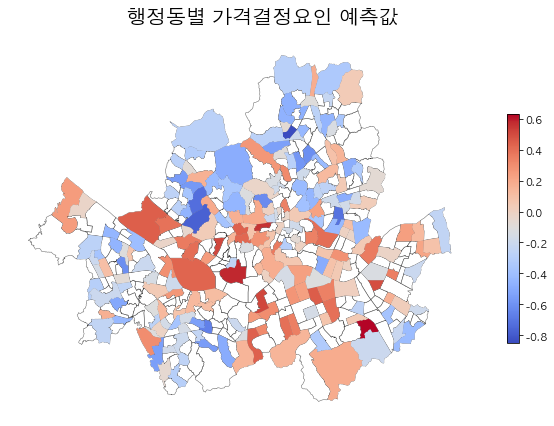

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

area_adm.geometry.plot(ax=ax, zorder=1, color='white', alpha=0.6, edgecolor='black', linewidth=0.5)
area_adm.plot(column='Prediction', ax=ax, legend=True, zorder=2, cmap='coolwarm', legend_kwds={'shrink': 0.6})

plt.axis('off')
plt.suptitle('행정동별 가격결정요인 예측값',fontsize=20)
plt.tight_layout()
plt.savefig(f'plots/resultplot.png', facecolor='white')

In [125]:
area_adm.dropna().sort_values(by=['Prediction'])

,ADM_DR_NM,geometry,Prediction
135,수유3동,"POLYGON ((202212.097 460767.746, 202213.474 46...",-0.848602
205,연희동,"POLYGON ((194648.695 453847.191, 194676.517 45...",-0.774209
197,홍은2동,"POLYGON ((194606.840 455246.758, 194612.039 45...",-0.727924
90,장안2동,"POLYGON ((206864.949 452542.482, 206906.816 45...",-0.712398
334,은천동,"POLYGON ((194742.834 443714.916, 194745.102 44...",-0.666507
...,...,...,...
347,반포2동,"POLYGON ((200132.601 444997.590, 200148.034 44...",0.510262
221,아현동,"POLYGON ((196437.302 450907.847, 196440.880 45...",0.513016
23,을지로동,"POLYGON ((200293.298 452231.984, 200310.878 45...",0.555143
46,한강로동,"POLYGON ((197640.806 448985.732, 197649.586 44...",0.580282
